# Simple RAG with RL

[![Python 3.7+](https://img.shields.io/badge/python-3.7+-blue.svg)](https://www.python.org/downloads/release/python-370/) [![Nebius AI](https://img.shields.io/badge/Nebius%20AI-LLM-brightgreen)](https://cloud.nebius.ai/services/llm-embedding) [![OpenAI](https://img.shields.io/badge/OpenAI-API-lightgrey)](https://openai.com/) [![Medium](https://img.shields.io/badge/Medium-Blog-black?logo=medium)](https://medium.com/@fareedkhandev/maximizing-simple-rag-performance-using-rl-rewards-in-python-d4c14cbadf59)

A simple RAG works in three simple steps:

1. **Indexing**: Break documents into chunks and convert to vector embeddings.

2. **Retrieval**: When a question is asked, find the most relevant chunks.

3. **Generation**: Combine the question with retrieved chunks and let the AI generate an answer using this information.

The actual problem is to generate an answer to a given question using the provided documents. Simple RAG often fails to generate accurate answers due to the lack of context in the retrieved chunks. In this notebook, we will use the `RL RAG` approach to generate answers to the given questions using the provided documents.

# Table of Contents

- [Setting Up the Environment](#setting-up-the-environment)
- [Data Preprocessing](#data-preprocessing)
- [Document Embedding Generation](#document-embedding-generation)
- [Vector Store Implementation](#vector-store-implementation)
- [Simple Retrieval Implementation](#simple-retrieval-implementation)
  - [Cosine Similarity](#cosine-similarity)
  - [Similarity Search](#similarity-search)
  - [LLM Response Generation](#llm-response-generation)
  - [Basic RAG Pipeline](#basic-rag-pipeline)
  - [Evaluation of Basic RAG](#evaluate-the-basic-rag-pipeline)
- [Reinforcement Learning for RAG](#reinforcement-learning-for-rag)
  - [State, Action Space, and Reward Methodology](#state-action-space-and-reward-methodology)
  - [Policy Network](#policy-network)
  - [Single RL Step](#single-rl-step)
  - [Training Parameters and Policy Update](#training-parameters-and-policy-update)
  - [Training Loop](#training-loop)
  - [Performance Comparison Logic](#performance-comparison-logic)
- [Evaluation Framework](#evaluation-framework)
- [Evaluating RL vs Simple RAG](#evaluating-rl-vs-simple-rag)
- [Saving Comparison Results](#saving-the-comparison-results)
- [Conclusion](#what-can-we-conclude)

## Setting Up the Environment

First, we need to import the necessary libraries and set up the environment. We will be using HuggingFace Models hosted under **Nebius** platform. Obviously, you can use your own models as long as they are compatible with OpenAI's API.

In [1]:
# Importing the os module for interacting with the operating system
import os

# Importing the OpenAI module for working with OpenAI's API
from openai import OpenAI

# Importing numpy for numerical operations
import numpy as np

# Importing json for working with JSON data
import json

# Typing module for type hints
from typing import Dict, List, Tuple, Optional, Union

Next, we need to initialize the client responsible for response and embedding generation.

In [2]:
# Set up the API connection using the OpenAI client
# Replace the base_url and api_key with your own values

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",  # Base URL for (eg. ollama api, anyother llm api provider)
    api_key= os.environ["NEBIUS_API_KEY"]  # API key for authentication 
)

## Data Preprocessing
Now that we have moved onto the data preprocessing stage, we need to load the data and preprocess it. Let's create a function that will load all the `.txt` files from a directory and return a list of documents.

In [3]:
# Function to load documents from a directory
def load_documents(directory_path: str) -> List[str]:
    """
    Load all text documents from the specified directory.

    Args:
        directory_path (str): Path to the directory containing text files.

    Returns:
        List[str]: A list of strings, where each string is the content of a text file.
    """
    documents = []  # Initialize an empty list to store document contents
    for filename in os.listdir(directory_path):  # Iterate through all files in the directory
        if filename.endswith(".txt"):  # Check if the file has a .txt extension
            # Open the file in read mode with UTF-8 encoding and append its content to the list
            with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
                documents.append(file.read())
    return documents  # Return the list of document contents

We need to create a function that performs chunking of the documents once they are loaded. We are using a `chunk_size` of `100` characters, but you can adjust it as per your requirements.

In [4]:
# Function to split documents into chunks
def split_into_chunks(documents: List[str], chunk_size: int = 30) -> List[str]:
    """
    Split documents into smaller chunks of specified size.

    Args:
        documents (List[str]): A list of document strings to be split into chunks.
        chunk_size (int): The maximum number of words in each chunk. Default is 100.

    Returns:
        List[str]: A list of chunks, where each chunk is a string containing up to `chunk_size` words.
    """
    chunks = []  # Initialize an empty list to store the chunks
    for doc in documents:  # Iterate through each document
        words = doc.split()  # Split the document into words
        # Create chunks of the specified size
        for i in range(0, len(words), chunk_size):
            chunk = " ".join(words[i:i + chunk_size])  # Join words to form a chunk
            chunks.append(chunk)  # Add the chunk to the list
    return chunks  # Return the list of chunks

This step is **optional**, where we preprocess each chunk by removing special characters, converting to lowercase, etc.

In [5]:
# Function to preprocess text (e.g., lowercasing, removing special characters)
def preprocess_text(text: str) -> str:
    """
    Preprocess the input text by converting it to lowercase and removing special characters.

    Args:
        text (str): The input text to preprocess.

    Returns:
        str: The preprocessed text with only alphanumeric characters and spaces.
    """
    # Convert the text to lowercase
    text = text.lower()
    # Remove special characters, keeping only alphanumeric characters and spaces
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    return text

However, if you are using the previous preprocessing step, you can simply create a function to preprocess the entire document.

In [6]:
# Function to preprocess all chunks
def preprocess_chunks(chunks: List[str]) -> List[str]:
    """
    Apply preprocessing to all text chunks.

    Args:
        chunks (List[str]): A list of text chunks to preprocess.

    Returns:
        List[str]: A list of preprocessed text chunks.
    """
    # Apply the preprocess_text function to each chunk in the list
    return [preprocess_text(chunk) for chunk in chunks]

Now that we have implemented all the functions for data preprocessing, we can load the documents from the directory, split them into chunks, and preprocess the chunks.

In [7]:
# Specify the directory path containing the text files
directory_path = "data"

# Load all text documents from the specified directory
documents = load_documents(directory_path)

# Split the loaded documents into smaller chunks of text
chunks = split_into_chunks(documents)

# Preprocess the chunks (e.g., lowercasing, removing special characters)
preprocessed_chunks = preprocess_chunks(chunks)

Print the first 200 characters of the first two chunks

In [8]:
# Print the first 2 preprocessed chunks, displaying only the first 200 characters of each chunk
for i in range(2):
    # Use slicing to limit the output to the first 200
    print(f"Chunk {i+1}: {preprocessed_chunks[i][:50]} ... ")
    print("-" * 50)  # Print a separator line

Chunk 1: quantum computing principles progress and possibil ... 
--------------------------------------------------
Chunk 2: process information in binary digits bits quantum  ... 
--------------------------------------------------


## Document Embedding Generation

In the previous step, we chunked our document. Now it's time to generate embeddings for the chunk dataset. When working with RAG, our knowledge base is typically quite large. Therefore, we need to perform embedding generation in batches. Let's create a core function to generate embeddings for the chunks in batches.

The embedding model we are using is `BAAI/bge-en-icl`.

In [9]:
# Function to generate embeddings for a single batch of text chunks
def generate_embeddings_batch(chunks_batch: List[str], model: str = "BAAI/bge-en-icl") -> List[List[float]]:
    """
    Generate embeddings for a batch of text chunks using the OpenAI client.

    Args:
        chunks_batch (List[str]): A batch of text chunks to generate embeddings for.
        model (str): The model to use for embedding generation. Default is "BAAI/bge-en-icl".

    Returns:
        List[List[float]]: A list of embeddings, where each embedding is a list of floats.
    """
    # Use the OpenAI client to create embeddings for the input batch
    response = client.embeddings.create(
        model=model,  # Specify the model to use for embedding generation
        input=chunks_batch  # Provide the batch of text chunks as input
    )
    # Extract embeddings from the response and return them
    embeddings = [item.embedding for item in response.data]
    return embeddings

Next, we will define a function to generate embeddings for all text chunks in batches. This function will take a list of text chunks as input and generate embeddings for each batch of chunks using the OpenAI client. The function will return a list of embeddings corresponding to all the text chunks.

In [10]:
# Function to generate embeddings for all chunks with batching
def generate_embeddings(chunks: List[str], batch_size: int = 10) -> np.ndarray:
    """
    Generate embeddings for all text chunks in batches.

    Args:
        chunks (List[str]): A list of text chunks to generate embeddings for.
        batch_size (int): The number of chunks to process in each batch. Default is 10.

    Returns:
        np.ndarray: A NumPy array containing embeddings for all chunks.
    """
    all_embeddings = []  # Initialize an empty list to store all embeddings

    # Iterate through the chunks in batches
    for i in range(0, len(chunks), batch_size):
        # Extract the current batch of chunks
        batch = chunks[i:i + batch_size]
        # Generate embeddings for the current batch
        embeddings = generate_embeddings_batch(batch)
        # Extend the list of all embeddings with the embeddings from the current batch
        all_embeddings.extend(embeddings)

    # Convert the list of embeddings to a NumPy array and return it
    return np.array(all_embeddings)

Let's create another function to save the embeddings to a file in JSON format.

In [11]:
# Function to save embeddings to a file
def save_embeddings(embeddings: np.ndarray, output_file: str) -> None:
    """
    Save embeddings to a JSON file.

    Args:
        embeddings (np.ndarray): A NumPy array containing the embeddings to save.
        output_file (str): The path to the output JSON file where embeddings will be saved.

    Returns:
        None
    """
    # Open the specified file in write mode with UTF-8 encoding
    with open(output_file, 'w', encoding='utf-8') as file:
        # Convert the NumPy array to a list and save it as JSON
        json.dump(embeddings.tolist(), file)

Now that we have implemented all the functions for embedding generation, we can proceed to generate embeddings for the preprocessed text chunks and save them to a JSON file.

In [12]:
# Ensure the chunks are preprocessed before generating embeddings
preprocessed_chunks = preprocess_chunks(chunks)

# Generate embeddings for the preprocessed chunks
embeddings = generate_embeddings(preprocessed_chunks)

# Save the generated embeddings to a JSON file named "embeddings.json"
save_embeddings(embeddings, "embeddings.json")

## Vector Store Implementation
Since we are not using any python libraries for vector storage, we will implement a simple vector store using a dictionary.

In [13]:
# Initialize an in-memory vector store as a dictionary
# The keys will be unique identifiers (integers), and the values will be dictionaries containing embeddings and corresponding text chunks
vector_store: dict[int, dict[str, object]] = {}

# Function to add embeddings and corresponding text chunks to the vector store
def add_to_vector_store(embeddings: np.ndarray, chunks: List[str]) -> None:
    """
    Add embeddings and their corresponding text chunks to the vector store.

    Args:
        embeddings (np.ndarray): A NumPy array containing the embeddings to add.
        chunks (List[str]): A list of text chunks corresponding to the embeddings.

    Returns:
        None
    """
    # Iterate over embeddings and chunks simultaneously
    for embedding, chunk in zip(embeddings, chunks):
        # Add each embedding and its corresponding chunk to the vector store
        # Use the current length of the vector store as the unique key
        vector_store[len(vector_store)] = {"embedding": embedding, "chunk": chunk}

## Simple Retrieval Implementation

We do know for retrieving the most similar text chunks to a given query, we can use the cosine similarity between the query embedding and the embeddings of all text chunks. The higher the cosine similarity, the more similar the text chunks are. We can then sort the chunks based on their similarity scores and return the top-k most similar chunks.
    
So, let's implement a simple cosine similarity-based retrieval function.

The cosine similarity between two vectors $A$ and $B$ is calculated as:

$$\text{cosine similarity} = \frac{A \cdot B}{||A|| \times ||B||} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \times \sqrt{\sum_{i=1}^{n} B_i^2}}$$

Where:
- $A \cdot B$ is the dot product of vectors $A$ and $B$
- $||A||$ and $||B||$ are the Euclidean norms (magnitudes) of the vectors
- $n$ is the dimension of the vectors

In [14]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    """
    Compute the cosine similarity between two vectors.

    Args:
        vec1 (np.ndarray): The first vector.
        vec2 (np.ndarray): The second vector.

    Returns:
        float: The cosine similarity between the two vectors, ranging from -1 to 1.
    """
    # Compute the dot product of the two vectors
    dot_product = np.dot(vec1, vec2)
    # Compute the magnitude (norm) of the first vector
    norm_vec1 = np.linalg.norm(vec1)
    # Compute the magnitude (norm) of the second vector
    norm_vec2 = np.linalg.norm(vec2)
    # Return the cosine similarity as the ratio of the dot product to the product of the norms
    return dot_product / (norm_vec1 * norm_vec2)

When we calculate the cosine similarity between a query and all the chunks, we can perform a similarity search. Based on the `top_k` parameter, we retrieve the top k most similar chunks.

In [15]:
# Function to perform similarity search in the vector store
def similarity_search(query_embedding: np.ndarray, top_k: int = 5) -> List[str]:
    """
    Perform similarity search in the vector store and return the top_k most similar chunks.

    Args:
        query_embedding (np.ndarray): The embedding vector of the query.
        top_k (int): The number of most similar chunks to retrieve. Default is 5.

    Returns:
        List[str]: A list of the top_k most similar text chunks.
    """
    similarities = []  # Initialize a list to store similarity scores and corresponding keys

    # Iterate through all items in the vector store
    for key, value in vector_store.items():
        # Compute the cosine similarity between the query embedding and the stored embedding
        similarity = cosine_similarity(query_embedding, value["embedding"])
        # Append the key and similarity score as a tuple to the list
        similarities.append((key, similarity))

    # Sort the list of similarities in descending order based on the similarity score
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Retrieve the top_k most similar chunks based on their keys
    return [vector_store[key]["chunk"] for key, _ in similarities[:top_k]]

Once we have the similarity search function ready, we can simply code a retrieval function on top of it that will provide the relevant chunks based on the query.

In [16]:
# Function to retrieve relevant document chunks for a query
def retrieve_relevant_chunks(query_text: str, top_k: int = 5) -> List[str]:
    """
    Retrieve the most relevant document chunks for a given query text.

    Args:
        query_text (str): The query text for which relevant chunks are to be retrieved.
        top_k (int): The number of most relevant chunks to retrieve. Default is 5.

    Returns:
        List[str]: A list of the top_k most relevant text chunks.
    """
    # Generate embedding for the query text using the embedding model
    query_embedding = generate_embeddings([query_text])[0]
    
    # Perform similarity search to find the most relevant chunks
    relevant_chunks = similarity_search(query_embedding, top_k=top_k)
    
    # Return the list of relevant chunks
    return relevant_chunks

Now that we have implemented all the functions for retrieval, we can proceed to test the retrieval system with a sample query.

In [17]:
# Add the generated embeddings and their corresponding preprocessed chunks to the vector store
add_to_vector_store(embeddings, preprocessed_chunks)

# Define a query text for which we want to retrieve relevant document chunks
query_text = "What is Quantum Computing?"

# Retrieve the most relevant chunks from the vector store based on the query text
relevant_chunks = retrieve_relevant_chunks(query_text)

# Print the first 50 characters of each retrieved relevant chunk
for idx, chunk in enumerate(relevant_chunks):
    print(f"Chunk {idx + 1}: {chunk[:50]} ... ")
    print("-" * 50)  # Print a separator line

Chunk 1: quantum computing principles progress and possibil ... 
--------------------------------------------------
Chunk 2: through distinct stages 1 nisq era current 2 error ... 
--------------------------------------------------
Chunk 3: quantum advantage and practical applications quant ... 
--------------------------------------------------
Chunk 4: process information in binary digits bits quantum  ... 
--------------------------------------------------
Chunk 5: measuring the correct answer quantum gates and cir ... 
--------------------------------------------------


## LLM Response Generation

When we have a query and a set of relevant document chunks, we can use a large language model (LLM) to generate a response based on the query and the retrieved information. In this section, we will use the OpenAI API to generate a response to a query by providing the query text and the relevant document chunks as context to the LLM.

First we need a function to construct the input prompt for the LLM, which includes the query text and the relevant document chunks as context.

In [18]:
# Function to construct a prompt with context
def construct_prompt(query: str, context_chunks: List[str]) -> str:
    """
    Construct a prompt by combining the query with the retrieved context chunks.

    Args:
        query (str): The query text for which the prompt is being constructed.
        context_chunks (List[str]): A list of relevant context chunks to include in the prompt.

    Returns:
        str: The constructed prompt to be used as input for the LLM.
    """
    # Combine all context chunks into a single string, separated by newlines
    context = "\n".join(context_chunks)
    
    # Define the system message to guide the LLM's behavior
    system_message = (
        "You are a helpful assistant. Only use the provided context to answer the question. "
        "If the context doesn't contain the information needed, say 'I don't have enough information to answer this question.'"
    )
    
    # Construct the final prompt by combining the system message, context, and query
    prompt = f"System: {system_message}\n\nContext:\n{context}\n\nQuestion:\n{query}\n\nAnswer:"
    
    return prompt

To generate an LLM response, we need to implement a function that takes the constructed input prompt and sends it to the OpenAI API for response generation.

In [19]:
# Function to generate a response using the OpenAI chat model
def generate_response(
    prompt: str,
    model: str = "google/gemma-2-2b-it",
    max_tokens: int = 512,
    temperature: float = 1,
    top_p: float = 0.9,
    top_k: int = 50
) -> str:
    """
    Generate a response from the OpenAI chat model based on the constructed prompt.

    Args:
        prompt (str): The input prompt to provide to the chat model.
        model (str): The model to use for generating the response. Default is "google/gemma-2-2b-it".
        max_tokens (int): Maximum number of tokens in the response. Default is 512.
        temperature (float): Sampling temperature for response diversity. Default is 0.5.
        top_p (float): Probability mass for nucleus sampling. Default is 0.9.
        top_k (int): Number of highest probability tokens to consider. Default is 50.

    Returns:
        str: The generated response from the chat model.
    """
    # Use the OpenAI client to create a chat completion
    response = client.chat.completions.create(
        model=model,  # Specify the model to use for generating the response
        max_tokens=max_tokens,  # Maximum number of tokens in the response
        temperature=temperature,  # Sampling temperature for response diversity
        top_p=top_p,  # Probability mass for nucleus sampling
        extra_body={  # Additional parameters for the request
            "top_k": top_k  # Number of highest probability tokens to consider
        },
        messages=[  # List of messages to provide context for the chat model
            {
                "role": "user",  # Role of the message sender (user in this case)
                "content": [  # Content of the message
                    {
                        "type": "text",  # Type of content (text in this case)
                        "text": prompt  # The actual prompt text
                    }
                ]
            }
        ]
    )
    # Return the content of the first choice in the response
    return response.choices[0].message.content

## Basic RAG Pipeline

We cannot run small pieces of code repeatedly. Therefore, we need to create a simple RAG pipeline that takes only one parameter, which is our query, and returns the LLM response.

In [20]:
# Function to implement the basic Retrieval-Augmented Generation (RAG) pipeline
def basic_rag_pipeline(query: str) -> str:
    """
    Implement the basic Retrieval-Augmented Generation (RAG) pipeline:
    retrieve relevant chunks, construct a prompt, and generate a response.

    Args:
        query (str): The input query for which a response is to be generated.

    Returns:
        str: The generated response from the LLM based on the query and retrieved context.
    """
    # Step 1: Retrieve the most relevant chunks for the given query
    relevant_chunks: List[str] = retrieve_relevant_chunks(query)
    
    # Step 2: Construct a prompt using the query and the retrieved chunks
    prompt: str = construct_prompt(query, relevant_chunks)
    
    # Step 3: Generate a response from the LLM using the constructed prompt
    response: str = generate_response(prompt)
    
    # Return the generated response
    return response

## Evaluate the basic RAG pipeline

Now that we have coded the basic RAG pipeline, we can use it for evaluation. Our evaluation queries contain different targeted segments, such as `factual_queries` and `complex_nature`. We are going to test the factual knowledge of our RAG pipeline.

Let's load our evaluation queries and their expected answers.

In [21]:
# Open the validation data file in read mode and load its content as a dictionary
with open('data/val_rl.json', 'r') as file:
    validation_data = json.load(file)

# Test the basic RAG pipeline with a sample query
sample_query = validation_data['basic_factual_questions'][0]['question']  # Extract the query text
expected_answer = validation_data['basic_factual_questions'][0]['answer']  # Extract the ground truth answer

# print the sample query and expected answer
print(f"Sample Query: {sample_query}\n")
print(f"Expected Answer: {expected_answer}\n")

Sample Query: What is the mathematical representation of a qubit in superposition?

Expected Answer: |ψ⟩ = α|0⟩ + β|1⟩, where α and β are complex numbers satisfying |α|² + |β|² = 1, representing the probability amplitudes for measuring the qubit in state |0⟩ or |1⟩ respectively.



Let's test the basic RAG pipeline with this eval query and see how well it performs.

In [22]:
# Print a message to indicate the start of the RAG pipeline
print("🔍 Running the Retrieval-Augmented Generation (RAG) pipeline...")
print(f"📥 Query: {sample_query}\n")

# Run the RAG pipeline and get the response
response = basic_rag_pipeline(sample_query)

# Print the response with better formatting
print("🤖 AI Response:")
print("-" * 50)
print(response.strip())
print("-" * 50)

# Print the ground truth answer for comparison
print("✅ Ground Truth Answer:")
print("-" * 50)
print(expected_answer)
print("-" * 50)

🔍 Running the Retrieval-Augmented Generation (RAG) pipeline...
📥 Query: What is the mathematical representation of a qubit in superposition?

🤖 AI Response:
--------------------------------------------------
ψ α0  β1
--------------------------------------------------
✅ Ground Truth Answer:
--------------------------------------------------
|ψ⟩ = α|0⟩ + β|1⟩, where α and β are complex numbers satisfying |α|² + |β|² = 1, representing the probability amplitudes for measuring the qubit in state |0⟩ or |1⟩ respectively.
--------------------------------------------------


The simple RAG pipeline doesn't seem to perform well in its current state. The generated response is not only irrelevant to the ground truth but also misses critical information.

But don't worry! In the upcoming steps, we will implement a Reinforcement Learning-based RAG pipeline to address these shortcomings. This will help us improve the retrieval and generation process, making the responses more accurate and contextually relevant.

Stay tuned as we take our RAG pipeline to the next level! 🚀

## Reinforcement Learning for RAG

Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by taking actions in an environment to maximize some notion of cumulative reward. Unlike supervised learning, the agent is not explicitly told which actions to take, but instead must discover which actions yield the most reward through trial and error.

Follow are the main components of a reinforcement learning system:

1. **Agent**: The learner or decision-maker
2. **Environment**: The world with which the agent interacts
3. **State (S)**: The current situation of the agent in the environment
4. **Action (A)**: A set of possible moves the agent can make
5. **Reward (R)**: Feedback from the environment after each action
6. **Policy (π)**: Strategy that the agent follows to determine the next action

The goal in reinforcement learning is to learn a policy π that maximizes the expected cumulative reward:

$$\pi^* = \arg\max_\pi \mathbb{E}\left[ \sum_{t=0}^{T} \gamma^t R_t \right]$$

Where:
- $\pi^*$ is the optimal policy
- $\gamma$ is the discount factor (0 ≤ γ ≤ 1)
- $R_t$ is the reward at time step t
- $T$ is the final time step

In the context of RAG systems, reinforcement learning can be used to:
- Improve retrieval by learning which documents are most helpful
- Refine prompt construction based on user feedback
- Optimize the generation process by learning from successful responses

## State, Action Space, and Reward Methodology

The very first step when coding an RL algorithm is to define three things:

- **State**: It is the current situation of the environment. In our case, the initial state is our simple RAG pipeline (query, context, response).
- **Action Space**: It is the decision that the agent takes based on the state. In our case, the actions can include changing the model, modifying the context, altering the query, etc.
- **Reward**: It is the feedback that the agent receives after taking an action. In our case, the reward can be the similarity between the generated response and the ground truth answer.

Our state will be changing constantly as we perform training. For that, we need to save the state after each `training episode` so that our RL agent can learn from it and avoid making the same mistakes again.

In [23]:
# Function to define the state representation for reinforcement learning
def define_state(
    query: str, 
    context_chunks: List[str], 
    rewritten_query: str = None, 
    previous_responses: List[str] = None, 
    previous_rewards: List[float] = None
) -> dict:
    """
    Define the state representation for the reinforcement learning agent.
    
    Args:
        query (str): The original user query.
        context_chunks (List[str]): Retrieved context chunks from the knowledge base.
        rewritten_query (str, optional): A reformulated version of the original query.
        previous_responses (List[str], optional): List of previously generated responses.
        previous_rewards (List[float], optional): List of rewards received for previous actions.
    
    Returns:
        dict: A dictionary representing the current state with all relevant information.
    """
    state = {
        "original_query": query,                                    # The initial query from the user
        "current_query": rewritten_query if rewritten_query else query,  # Current version of the query (may be rewritten)
        "context": context_chunks,                                 # Retrieved context chunks from the knowledge base
        "previous_responses": previous_responses if previous_responses else [],  # History of generated responses
        "previous_rewards": previous_rewards if previous_rewards else []         # History of received rewards
    }
    return state

We have defined the state representation for the RL agent, including the user query, retrieved context chunks, rewritten query (if any), and histories of responses and rewards. This state will guide the agent in generating better responses. 

Next we need to define the action space for the reinforcement learning agent. The action space consists of the set of possible actions that the agent can take at each step. In this case, we define four actions:
- `rewrite_query`: Reformulate the original query to improve retrieval
- `expand_context`: Retrieve additional context chunks
- `filter_context`: Remove irrelevant context chunks
- `generate_response`: Generate a response based on the current query and context

In [24]:
# Function to define the action space for reinforcement learning
def define_action_space() -> List[str]:
    """
    Define the set of possible actions the reinforcement learning agent can take.
    
    Actions include:
    - rewrite_query: Reformulate the original query to improve retrieval
    - expand_context: Retrieve additional context chunks
    - filter_context: Remove irrelevant context chunks
    - generate_response: Generate a response based on current query and context
    
    Returns:
        List[str]: A list of available actions.
    """

    # Define the set of actions the agent can take
    actions = ["rewrite_query", "expand_context", "filter_context", "generate_response"]
    return actions

Obviously, when our RL agent takes an action, it will be based on the current state and the action space. It will be rewarded based on the quality of the response generated by the RAG pipeline. The reward function will be based on the cosine similarity between the generated response and the ground truth answer.

In [25]:
# Function to calculate the reward based on response quality
def calculate_reward(response: str, ground_truth: str) -> float:
    """
    Calculate a reward value by comparing the generated response to the ground truth.
    
    Uses cosine similarity between the embeddings of the response and ground truth
    to determine how close the response is to the expected answer.
    
    Args:
        response (str): The generated response from the RAG pipeline.
        ground_truth (str): The expected correct answer.
    
    Returns:
        float: A reward value between -1 and 1, where higher values indicate 
               greater similarity to the ground truth.
    """
    # Generate embeddings for both the response and ground truth
    response_embedding = generate_embeddings([response])[0]
    ground_truth_embedding = generate_embeddings([ground_truth])[0]
    
    # Calculate cosine similarity between the embeddings as the reward
    similarity = cosine_similarity(response_embedding, ground_truth_embedding)
    return similarity

Our goal is to maximize the reward by generating responses that are similar to the ground truth answer. Higher reward values indicate that the generated response is more aligned with the expected answer.

## Action Function Logic

Now that we have defined the action space, we need to implement the logic for each action. This logic will determine how the RAG pipeline should be modified based on the action taken by the RL agent.

Just to revisit, the four actions are:
- `rewrite_query`: Reformulate the original query to improve retrieval
- `expand_context`: Retrieve additional context chunks
- `filter_context`: Remove irrelevant context chunks
- `generate_response`: Generate a response based on the current query and context

Let's create our first action logic for the agent. The first action we will implement is the `rewrite_query` action, which involves reformulating the original user query to improve retrieval performance. This action is crucial for enhancing the relevance of the retrieved context and generating more accurate responses.

In [26]:
# Function to rewrite the query for better document retrieval
def rewrite_query(
    query: str, 
    context_chunks: List[str], 
    model: str = "google/gemma-2-2b-it", 
    max_tokens: int = 100, 
    temperature: float = 0.3
) -> str:
    """
    Use the LLM to rewrite the query for better document retrieval.

    Args:
        query (str): The original query text.
        context_chunks (List[str]): A list of context chunks retrieved so far.
        model (str): The model to use for generating the rewritten query. Default is "google/gemma-2-2b-it".
        max_tokens (int): Maximum number of tokens in the rewritten query. Default is 100.
        temperature (float): Sampling temperature for response diversity. Default is 0.3.

    Returns:
        str: The rewritten query optimized for document retrieval.
    """
    # Construct a prompt for the LLM to rewrite the query
    rewrite_prompt = f"""
    You are a query optimization assistant. Your task is to rewrite the given query to make it more effective 
    for retrieving relevant information. The query will be used for document retrieval.
    
    Original query: {query}
    
    Based on the context retrieved so far:
    {' '.join(context_chunks[:2]) if context_chunks else 'No context available yet'}
    
    Rewrite the query to be more specific and targeted to retrieve better information.
    Rewritten query:
    """
    
    # Use the LLM to generate a rewritten query
    response = client.chat.completions.create(
        model=model, # Specify the model to use for generating the response
        max_tokens=max_tokens, # Maximum number of tokens in the response
        temperature=temperature, # Sampling temperature for response diversity
        messages=[
            {
                "role": "user",
                "content": rewrite_prompt
            }
        ]
    )
    
    # Extract and return the rewritten query from the response
    rewritten_query = response.choices[0].message.content.strip()
    return rewritten_query

This action is crucial for enhancing the relevance of the retrieved context and generating more accurate responses.

Let's code our next action logic, which is to expand the context by retrieving additional chunks. We will use the existing function `retrieve_relevant_chunks` to get more context chunks and then filter out any duplicates from the current context. We will limit the number of new chunks to be added to the context to a specified top_k value.

In [27]:
# Function to expand the context by retrieving additional chunks
def expand_context(query: str, current_chunks: List[str], top_k: int = 3) -> List[str]:
    """
    Expand the context by retrieving additional chunks.

    Args:
        query (str): The query text for which additional context is needed.
        current_chunks (List[str]): The current list of context chunks.
        top_k (int): The number of additional chunks to retrieve. Default is 3.

    Returns:
        List[str]: The expanded list of context chunks including new unique chunks.
    """
    # Retrieve more chunks than currently available
    additional_chunks = retrieve_relevant_chunks(query, top_k=top_k + len(current_chunks))
    
    # Filter out chunks that are already in the current context
    new_chunks = []
    for chunk in additional_chunks:
        if chunk not in current_chunks:
            new_chunks.append(chunk)
    
    # Add new unique chunks to the current context, limited to top_k
    expanded_context = current_chunks + new_chunks[:top_k]
    return expanded_context

We need to filter the context to keep only the most relevant chunks for the query. This filtering step is crucial to ensure that the context provided to the language model is concise and focused on the most relevant information.

In [28]:
# Function to filter the context to keep only the most relevant chunks
def filter_context(query: str, context_chunks: List[str]) -> List[str]:
    """
    Filter the context to keep only the most relevant chunks.

    Args:
        query (str): The query text for which relevance is calculated.
        context_chunks (List[str]): The list of context chunks to filter.

    Returns:
        List[str]: A filtered list of the most relevant context chunks.
    """
    if not context_chunks:
        return []
        
    # Generate embeddings for the query and each chunk
    query_embedding = generate_embeddings([query])[0]
    chunk_embeddings = [generate_embeddings([chunk])[0] for chunk in context_chunks]
    
    # Calculate relevance scores for each chunk
    relevance_scores = []
    for chunk_embedding in chunk_embeddings:
        score = cosine_similarity(query_embedding, chunk_embedding)
        relevance_scores.append(score)
    
    # Sort chunks by relevance scores in descending order
    sorted_chunks = [x for _, x in sorted(zip(relevance_scores, context_chunks), reverse=True)]
    
    # Keep the top 5 most relevant chunks or fewer if less than 5 are available
    filtered_chunks = sorted_chunks[:min(5, len(sorted_chunks))]
    
    return filtered_chunks

This action will help the agent explore more information relevant to the query.

## Policy Network

Previously, we defined our state, actions, and reward logic. Next, we need to create a policy network that will select an action based on the current state.

A policy network is a function that takes the current state and the action space as input and returns the selected action based on the state.

The policy network can use a simple heuristic to select an action based on the current state. For example, if there are no previous responses, the policy network can prioritize rewriting the query. If the context has too many chunks, the policy network can choose to filter the context.

In [29]:
# Function to define a policy network to select an action based on the state
def policy_network(
    state: dict, 
    action_space: List[str], 
    epsilon: float = 0.2
) -> str:
    """
    Define a policy network to select an action based on the current state using an epsilon-greedy strategy.

    Args:
        state (dict): The current state of the environment, including query, context, responses, and rewards.
        action_space (List[str]): The list of possible actions the agent can take.
        epsilon (float): The probability of choosing a random action for exploration. Default is 0.2.

    Returns:
        str: The selected action from the action space.
    """
    # Use epsilon-greedy strategy: random exploration vs. exploitation
    if np.random.random() < epsilon:
        # Exploration: randomly select an action from the action space
        action = np.random.choice(action_space)
    else:
        # Exploitation: select the best action based on the current state using a simple heuristic

        # If there are no previous responses, prioritize rewriting the query
        if len(state["previous_responses"]) == 0:
            action = "rewrite_query"
        # If there are previous responses but the rewards are low, try expanding the context
        elif state["previous_rewards"] and max(state["previous_rewards"]) < 0.7:
            action = "expand_context"
        # If the context has too many chunks, try filtering the context
        elif len(state["context"]) > 5:
            action = "filter_context"
        # Otherwise, generate a response
        else:
            action = "generate_response"
    
    return action

So our policy network works like this:
- If there are no previous responses, prioritize rewriting the query.
- If there are previous responses but the rewards are low, try expanding the context.
- If the context has too many chunks, try filtering the context.
- Otherwise, generate a response.

## Single RL Step

We have coded an important component of the RL pipeline. For any developer who has done any kind of training, there exists a training loop where each iteration is a single step in which the RL agent takes an action, rewards are calculated, states are updated, and so on. So, we need to code a single step of our training loop. Let's do that.

In [30]:
# Function to perform a single RL step
def rl_step(
    state: dict, 
    action_space: List[str], 
    ground_truth: str
) -> tuple[dict, str, float, str]:
    """
    Perform a single RL step: select an action, execute it, and calculate the reward.

    Args:
        state (dict): The current state of the environment, including query, context, responses, and rewards.
        action_space (List[str]): The list of possible actions the agent can take.
        ground_truth (str): The expected correct answer to calculate the reward.

    Returns:
        tuple: A tuple containing:
            - state (dict): The updated state after executing the action.
            - action (str): The action selected by the policy network.
            - reward (float): The reward received for the action.
            - response (str): The response generated (if applicable).
    """
    # Select an action using the policy network
    action: str = policy_network(state, action_space)
    response: str = None  # Initialize response as None
    reward: float = 0  # Initialize reward as 0

    # Execute the selected action
    if action == "rewrite_query":
        # Rewrite the query to improve retrieval
        rewritten_query: str = rewrite_query(state["original_query"], state["context"])
        state["current_query"] = rewritten_query  # Update the current query in the state
        # Retrieve new context based on the rewritten query
        new_context: List[str] = retrieve_relevant_chunks(rewritten_query)
        state["context"] = new_context  # Update the context in the state

    elif action == "expand_context":
        # Expand the context by retrieving additional chunks
        expanded_context: List[str] = expand_context(state["current_query"], state["context"])
        state["context"] = expanded_context  # Update the context in the state

    elif action == "filter_context":
        # Filter the context to keep only the most relevant chunks
        filtered_context: List[str] = filter_context(state["current_query"], state["context"])
        state["context"] = filtered_context  # Update the context in the state

    elif action == "generate_response":
        # Construct a prompt using the current query and context
        prompt: str = construct_prompt(state["current_query"], state["context"])
        # Generate a response using the LLM
        response: str = generate_response(prompt)
        # Calculate the reward based on the similarity between the response and the ground truth
        reward: float = calculate_reward(response, ground_truth)
        # Update the state with the new response and reward
        state["previous_responses"].append(response)
        state["previous_rewards"].append(reward)

    # Return the updated state, selected action, reward, and response
    return state, action, reward, response

In our single step function, we first select an action using the policy network. The policy network uses an epsilon-greedy strategy to balance exploration and exploitation. If the random number is less than epsilon, we choose a random action from the action space for exploration. Otherwise, we select the best action based on the current state using a simple heuristic.

## Training Parameters and Policy Update

We need to define some training parameters for our training loop and also define a function to update the policy based on the rewards received.

Though the training parameters function is **optional**, it can be used for advanced implementations of the RL pipeline.

In [31]:
# Function to initialize training parameters
def initialize_training_params() -> Dict[str, Union[float, int]]:
    """
    Initialize training parameters such as learning rate, number of episodes, and discount factor.

    Returns:
        Dict[str, Union[float, int]]: A dictionary containing the initialized training parameters.
    """
    params = {
        "learning_rate": 0.01,  # Learning rate for policy updates
        "num_episodes": 100,   # Total number of training episodes
        "discount_factor": 0.99  # Discount factor for future rewards
    }
    return params

Similar to how our state changes after each step in the RL process, the policy also needs to be updated based on the rewards received. The update_policy function takes the current policy, state, action, reward, and learning rate as input and returns the updated policy.

In [32]:
# Function to update policy based on reward
def update_policy(
    policy: Dict[str, Dict[str, Union[float, str]]], 
    state: Dict[str, object], 
    action: str, 
    reward: float, 
    learning_rate: float
) -> Dict[str, Dict[str, Union[float, str]]]:
    """
    Update the policy based on the reward received.

    Args:
        policy (Dict[str, Dict[str, Union[float, str]]]): The current policy to be updated.
        state (Dict[str, object]): The current state of the environment.
        action (str): The action taken by the agent.
        reward (float): The reward received for the action.
        learning_rate (float): The learning rate for updating the policy.

    Returns:
        Dict[str, Dict[str, Union[float, str]]]: The updated policy.
    """
    # Example: Simple policy update (to be replaced with a proper RL algorithm)
    policy[state["query"]] = {
        "action": action,  # Store the action taken
        "reward": reward   # Store the reward received
    }
    return policy

In the above `update_policy` logic, we store the action taken and the reward received for each query in the policy dictionary. In a more advanced RL algorithm, the policy update would involve more sophisticated methods such as policy gradients or Q-learning.

Finally, we need to implement progress tracking logic to monitor the training process. This will help us understand how the model is learning and improving over time.

In [33]:
# Function to track training progress
def track_progress(
    episode: int, 
    reward: float, 
    rewards_history: List[float]
) -> List[float]:
    """
    Track the training progress by storing rewards for each episode.

    Args:
        episode (int): The current episode number.
        reward (float): The reward received in the current episode.
        rewards_history (List[float]): A list to store the rewards for all episodes.

    Returns:
        List[float]: The updated rewards history.
    """
    # Append the current reward to the rewards history
    rewards_history.append(reward)
    
    # Print progress every 10 episodes
    print(f"Episode {episode}: Reward = {reward}")
    
    return rewards_history

## Training Loop

Now that we have coded every part of the training loop, we can put it all together in a single function that implements the training loop for the RL-enhanced RAG system.

In [34]:
# Function to implement the training loop
def training_loop(
    query_text: str, 
    ground_truth: str, 
    params: Optional[Dict[str, Union[float, int]]] = None
) -> Tuple[Dict[str, Dict[str, Union[float, str]]], List[float], List[List[str]], Optional[str]]:
    """
    Implement the training loop for RL-enhanced RAG.

    Args:
        query_text (str): The input query text for the RAG pipeline.
        ground_truth (str): The expected correct answer for the query.
        params (Optional[Dict[str, Union[float, int]]]): Training parameters such as learning rate, 
            number of episodes, and discount factor. If None, default parameters are initialized.

    Returns:
        Tuple: A tuple containing:
            - policy (Dict[str, Dict[str, Union[float, str]]]): The updated policy after training.
            - rewards_history (List[float]): A list of rewards received in each episode.
            - actions_history (List[List[str]]): A list of actions taken in each episode.
            - best_response (Optional[str]): The best response generated during training.
    """
    # Initialize training parameters if not provided
    if params is None:
        params = initialize_training_params()
    
    # Initialize variables to track progress
    rewards_history: List[float] = []  # List to store rewards for each episode
    actions_history: List[List[str]] = []  # List to store actions taken in each episode
    policy: Dict[str, Dict[str, Union[float, str]]] = {}  # Policy dictionary to store actions and rewards
    action_space: List[str] = define_action_space()  # Define the action space
    best_response: Optional[str] = None  # Variable to store the best response
    best_reward: float = -1  # Initialize the best reward to a very low value
    
    # Get initial performance from the simple RAG pipeline for comparison
    simple_response: str = basic_rag_pipeline(query_text)
    simple_reward: float = calculate_reward(simple_response, ground_truth)
    print(f"Simple RAG reward: {simple_reward:.4f}")

    # Start the training loop
    for episode in range(params["num_episodes"]):
        # Reset the environment with the same query
        context_chunks: List[str] = retrieve_relevant_chunks(query_text)
        state: Dict[str, object] = define_state(query_text, context_chunks)
        episode_reward: float = 0  # Initialize the reward for the current episode
        episode_actions: List[str] = []  # Initialize the list of actions for the current episode
        
        # Maximum number of steps per episode to prevent infinite loops
        for step in range(10):
            # Perform a single RL step
            state, action, reward, response = rl_step(state, action_space, ground_truth)
            episode_actions.append(action)  # Record the action taken
            
            # If a response is generated, end the episode
            if response:
                episode_reward = reward  # Update the episode reward
                
                # Track the best response and reward
                if reward > best_reward:
                    best_reward = reward
                    best_response = response
                
                break  # Exit the loop as the episode ends
        
        # Update rewards and actions history
        rewards_history.append(episode_reward)
        actions_history.append(episode_actions)
        
        # Print progress every 5 episodes
        if episode % 5 == 0:
            print(f"Episode {episode}: Reward = {episode_reward:.4f}, Actions = {episode_actions}")
    
    # Compare the best RL-enhanced RAG reward with the simple RAG reward
    improvement: float = best_reward - simple_reward
    print(f"\nTraining completed:")
    print(f"Simple RAG reward: {simple_reward:.4f}")
    print(f"Best RL-enhanced RAG reward: {best_reward:.4f}")
    print(f"Improvement: {improvement:.4f} ({improvement * 100:.2f}%)")

    return policy, rewards_history, actions_history, best_response

This function will take the input query text, the expected ground truth answer, and optionally some training parameters. It will return the updated policy, a list of rewards received in each episode, a list of actions taken in each episode, and the best response generated during training.

In more detail, the `training_loop` function will:
- Initialize training parameters if not provided.
- Get the initial performance from the simple RAG pipeline for comparison.
- Start the training loop for the specified number of episodes.
- Perform a single RL step in each episode.
- Update rewards and actions history for each episode.
- Print progress every 5 episodes.
- Compare the best RL-enhanced RAG reward with the simple RAG reward.
- Return the updated policy, rewards history, actions history, and the best response generated during training.

## Performance Comparison Logic

Although we can manually compare the simple RAG pipeline with the RL-based RAG pipeline, a function can definitely help us in this regard. So, let's define a function to compare the performance of the simple RAG pipeline with the RL-enhanced RAG pipeline.

In [35]:
# Function to compare Simple RAG vs RL-Enhanced RAG
def compare_rag_approaches(query_text: str, ground_truth: str) -> Tuple[str, str, float, float]:
    """
    Compare the outputs of simple RAG versus RL-enhanced RAG.

    Args:
        query_text (str): The input query text for the RAG pipeline.
        ground_truth (str): The expected correct answer for the query.

    Returns:
        Tuple[str, str, float, float]: A tuple containing:
            - simple_response (str): The response generated by the simple RAG pipeline.
            - best_rl_response (str): The best response generated by the RL-enhanced RAG pipeline.
            - simple_similarity (float): The similarity score of the simple RAG response to the ground truth.
            - rl_similarity (float): The similarity score of the RL-enhanced RAG response to the ground truth.
    """
    print("=" * 80)
    print(f"Query: {query_text}")
    print("=" * 80)
    
    # Step 1: Generate a response using the simple RAG pipeline
    # The basic RAG pipeline retrieves relevant chunks and generates a response without reinforcement learning.
    simple_response: str = basic_rag_pipeline(query_text)
    # Calculate the similarity score between the simple RAG response and the ground truth.
    simple_similarity: float = calculate_reward(simple_response, ground_truth)
    
    print("\nSimple RAG Output:")
    print("-" * 40)
    print(simple_response)
    print(f"Similarity to ground truth: {simple_similarity:.4f}")
    
    # Step 2: Train the RL-enhanced RAG model
    print("\nTraining RL-enhanced RAG model...")
    # Initialize training parameters (e.g., learning rate, number of episodes, discount factor).
    params: Dict[str, float | int] = initialize_training_params()
    # Set the number of episodes to a smaller value for demonstration purposes.
    params["num_episodes"] = 5
    
    # Run the training loop for the RL-enhanced RAG model.
    # This loop trains the model to optimize its responses using reinforcement learning.
    _, rewards_history, actions_history, best_rl_response = training_loop(
        query_text, ground_truth, params
    )
    
    # If no response was generated during training, generate one using the current query and context.
    if best_rl_response is None:
        # Retrieve relevant chunks for the query.
        context_chunks: List[str] = retrieve_relevant_chunks(query_text)
        # Construct a prompt using the query and retrieved context.
        prompt: str = construct_prompt(query_text, context_chunks)
        # Generate a response using the language model.
        best_rl_response: str = generate_response(prompt)
    
    # Calculate the similarity score between the RL-enhanced RAG response and the ground truth.
    rl_similarity: float = calculate_reward(best_rl_response, ground_truth)
    
    print("\nRL-enhanced RAG Output:")
    print("-" * 40)
    print(best_rl_response)
    print(f"Similarity to ground truth: {rl_similarity:.4f}")
    
    # Step 3: Evaluate and compare the results
    # Calculate the improvement in similarity score achieved by the RL-enhanced RAG model.
    improvement: float = rl_similarity - simple_similarity
    
    print("\nEvaluation Results:")
    print("-" * 40)
    print(f"Simple RAG similarity to ground truth: {simple_similarity:.4f}")
    print(f"RL-enhanced RAG similarity to ground truth: {rl_similarity:.4f}")
    print(f"Improvement: {improvement * 100:.2f}%")
    
    # Step 4: Plot the reward history (if there are enough episodes and matplotlib is available)
    if len(rewards_history) > 1:
        try:
            import matplotlib.pyplot as plt
            # Create a plot to visualize the reward history during RL training.
            plt.figure(figsize=(10, 6))
            plt.plot(rewards_history)
            plt.title('Reward History During RL Training')
            plt.xlabel('Episode')
            plt.ylabel('Reward')
            plt.grid(True)
            plt.show()
        except ImportError:
            # If matplotlib is not available, print a message instead of plotting.
            print("Matplotlib not available for plotting rewards")
    
    # Return the results: responses and similarity scores for both approaches.
    return simple_response, best_rl_response, simple_similarity, rl_similarity

So our performance comparison logic is not very complicated but is based on 4 steps:
1. Generate a response using the simple RAG pipeline.
2. Train the RL-enhanced RAG model using the training loop.
3. Evaluate and compare the results.
4. Plot the reward history (if available).

## Evaluation Framework (**Optional**)

This step is optional but in case you want to evaluate all the eval queries in the validation data, you can use the following code.

First, to check the relevance of the retrieved chunks and the ground truth, we need to have a function that evaluates the relevance of the retrieved chunks.

In [36]:
# Function to evaluate relevance of retrieved chunks
def evaluate_relevance(retrieved_chunks: List[str], ground_truth_chunks: List[str]) -> float:
    """
    Evaluate the relevance of retrieved chunks by comparing them to ground truth chunks.

    Args:
        retrieved_chunks (List[str]): A list of text chunks retrieved by the system.
        ground_truth_chunks (List[str]): A list of ground truth text chunks for comparison.

    Returns:
        float: The average relevance score between the retrieved chunks and the ground truth chunks.
    """
    relevance_scores: List[float] = []  # Initialize a list to store relevance scores

    # Iterate through pairs of retrieved and ground truth chunks
    for retrieved, ground_truth in zip(retrieved_chunks, ground_truth_chunks):
        # Calculate the cosine similarity between the embeddings of the retrieved and ground truth chunks
        relevance: float = cosine_similarity(
            generate_embeddings([retrieved])[0],
            generate_embeddings([ground_truth])[0]
        )
        # Append the relevance score to the list
        relevance_scores.append(relevance)

    # Return the average relevance score
    return np.mean(relevance_scores)

To evaluate the accuracy of the generated responses, we can use the cosine similarity between the embeddings of the generated responses and the ground truth. So let's define a function to evaluate the accuracy of the responses based on this similarity metric.

In [37]:
# Function to evaluate the accuracy of generated responses
def evaluate_accuracy(responses: List[str], ground_truth_responses: List[str]) -> float:
    """
    Evaluate the accuracy of generated responses by comparing them to ground truth responses.

    Args:
        responses (List[str]): A list of generated responses to evaluate.
        ground_truth_responses (List[str]): A list of ground truth responses to compare against.

    Returns:
        float: The average accuracy score, calculated as the mean cosine similarity 
               between the embeddings of the generated responses and the ground truth responses.
    """
    accuracy_scores: List[float] = []  # Initialize a list to store accuracy scores

    # Iterate through each pair of generated response and ground truth response
    for response, ground_truth in zip(responses, ground_truth_responses):
        # Calculate the cosine similarity between the embeddings of the response and ground truth
        accuracy: float = cosine_similarity(
            generate_embeddings([response])[0],
            generate_embeddings([ground_truth])[0]
        )
        # Append the accuracy score to the list
        accuracy_scores.append(accuracy)

    # Return the mean of the accuracy scores
    return np.mean(accuracy_scores)

We also need to measure the response quality and assign a relevant score for it to be used in the reinforcement learning process.

In [38]:
# Function to evaluate response quality
def evaluate_response_quality(responses: List[str]) -> float:
    """
    Evaluate the quality of responses using a heuristic or external model.

    Args:
        responses (List[str]): A list of generated responses to evaluate.

    Returns:
        float: The average quality score of the responses, ranging from 0 to 1.
    """
    quality_scores: List[float] = []  # Initialize a list to store quality scores for each response

    for response in responses:
        # Example heuristic: Calculate a quality score based on response length
        # Normalize the length by a maximum of 100 words and cap the score at 1.0
        quality: float = len(response.split()) / 100
        quality_scores.append(min(quality, 1.0))  # Append the capped quality score to the list

    # Return the average quality score across all responses
    return np.mean(quality_scores)

Then we can evaluate the performance of the RL-enhanced RAG model on the validation dataset:

In [39]:
# Function to evaluate RAG performance
def evaluate_rag_performance(
    queries: List[str], 
    ground_truth_chunks: List[str], 
    ground_truth_responses: List[str]
) -> Dict[str, float]:
    """
    Evaluate the performance of the RAG pipeline using relevance, accuracy, and response quality metrics.

    Args:
        queries (List[str]): A list of query strings to evaluate.
        ground_truth_chunks (List[str]): A list of ground truth text chunks corresponding to the queries.
        ground_truth_responses (List[str]): A list of ground truth responses corresponding to the queries.

    Returns:
        Dict[str, float]: A dictionary containing the average relevance, accuracy, and quality scores.
    """
    # Initialize lists to store scores for each metric
    relevance_scores: List[float] = []
    accuracy_scores: List[float] = []
    quality_scores: List[float] = []

    # Iterate through each query and its corresponding ground truth data
    for query, ground_truth_chunk, ground_truth_response in zip(queries, ground_truth_chunks, ground_truth_responses):
        # Retrieve relevant chunks for the query
        retrieved_chunks: List[str] = retrieve_relevant_chunks(query)
        
        # Evaluate the relevance of the retrieved chunks compared to the ground truth chunk
        relevance: float = evaluate_relevance(retrieved_chunks, [ground_truth_chunk])
        relevance_scores.append(relevance)

        # Generate a response using the basic RAG pipeline
        response: str = basic_rag_pipeline(query)
        
        # Evaluate the accuracy of the generated response compared to the ground truth response
        accuracy: float = evaluate_accuracy([response], [ground_truth_response])
        accuracy_scores.append(accuracy)

        # Evaluate the quality of the generated response
        quality: float = evaluate_response_quality([response])
        quality_scores.append(quality)

    # Calculate the average scores for each metric
    avg_relevance: float = np.mean(relevance_scores)
    avg_accuracy: float = np.mean(accuracy_scores)
    avg_quality: float = np.mean(quality_scores)

    # Return the average scores as a dictionary
    return {
        "average_relevance": avg_relevance,
        "average_accuracy": avg_accuracy,
        "average_quality": avg_quality
    }

## Evaluating (RL vs Simple) RAG

Ah, the moment of truth! Let's evaluate the performance of the simple RAG pipeline against the RL-enhanced RAG pipeline on our factual query, where the simple RAG previously failed to provide the correct answer. Let's see if the RL-enhanced RAG pipeline can perform better.

Let's revisit our evaluation query and see what the simple RAG pipeline generates for it.

In [40]:
# Print a message to indicate the start of the RAG pipeline
print("🔍 Running the Retrieval-Augmented Generation (RAG) pipeline...")
print(f"📥 Query: {sample_query}\n")

# Run the RAG pipeline and get the response
response = basic_rag_pipeline(sample_query)

# Print the response with better formatting
print("🤖 AI Response:")
print("-" * 50)
print(response.strip())
print("-" * 50)

# Print the ground truth answer for comparison
print("✅ Ground Truth Answer:")
print("-" * 50)
print(expected_answer)
print("-" * 50)

🔍 Running the Retrieval-Augmented Generation (RAG) pipeline...
📥 Query: What is the mathematical representation of a qubit in superposition?



🤖 AI Response:
--------------------------------------------------
ψ  α0  β1
--------------------------------------------------
✅ Ground Truth Answer:
--------------------------------------------------
|ψ⟩ = α|0⟩ + β|1⟩, where α and β are complex numbers satisfying |α|² + |β|² = 1, representing the probability amplitudes for measuring the qubit in state |0⟩ or |1⟩ respectively.
--------------------------------------------------


Query: What is the mathematical representation of a qubit in superposition?

Simple RAG Output:
----------------------------------------
ψ = α0 + β1  where α and β are complex numbers satisfying α² = 1 

Similarity to ground truth: 0.7728

Training RL-enhanced RAG model...
Simple RAG reward: 0.6997
Episode 0: Reward = 0.0000, Actions = ['rewrite_query', 'rewrite_query', 'rewrite_query', 'rewrite_query', 'rewrite_query', 'rewrite_query', 'rewrite_query', 'rewrite_query', 'rewrite_query', 'rewrite_query']

Training completed:
Simple RAG reward: 0.6997
Best RL-enhanced RAG reward: 0.9353
Improvement: 0.2356 (23.56%)

RL-enhanced RAG Output:
----------------------------------------
The mathematical representation of a qubit in superposition is ψ α0  β1, where α and β are complex numbers satisfying α² + β² = 1. This representation signifies the probability amplitudes for measuring the qubit in states 0 or 1 respectively. 

Similarity to ground truth: 0.9353

Evaluation Results:
------------

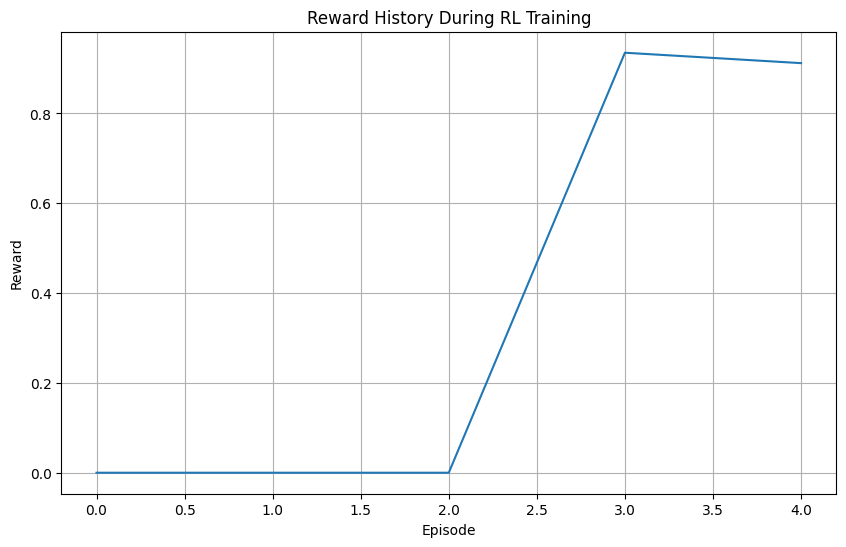

In [41]:
# Compare the performance of the simple RAG pipeline and the RL-enhanced RAG pipeline
# using the sample query and its expected answer.
# The function returns:
# - simple_response: The response generated by the simple RAG pipeline.
# - rl_response: The best response generated by the RL-enhanced RAG pipeline.
# - simple_sim: The similarity score of the simple RAG response to the ground truth.
# - rl_sim: The similarity score of the RL-enhanced RAG response to the ground truth.
simple_response, rl_response, simple_sim, rl_sim = compare_rag_approaches(sample_query, expected_answer)

You can clearly see that the response generated by the RL-enhanced RAG model is more accurate and relevant compared to the simple RAG pipeline. The improvement in similarity to the ground truth is evident, indicating that the RL-enhanced model has learned to generate better responses through training.

## Saving the Comparison Results

After implementing the RL algorithm, we can save the comparison results to check the performance of the RL implementation later.

In [42]:
# Save the results for later comparison
results = {
    "query": query_text,  # The input query text
    "ground_truth": expected_answer,  # The expected correct answer for the query
    "simple_rag": {
        "response": simple_response,  # The response generated by the simple RAG pipeline
        "similarity": float(simple_sim)  # The similarity score of the simple RAG response to the ground truth
    },
    "rl_rag": {
        "response": rl_response,  # The response generated by the RL-enhanced RAG pipeline
        "similarity": float(rl_sim)  # The similarity score of the RL-enhanced RAG response to the ground truth
    },
    "improvement": float(rl_sim - simple_sim)  # The improvement in similarity score achieved by RL-enhanced RAG
}

# Save the results to a JSON file for future reference
with open('rl_rag_results.json', 'w') as f:
    json.dump(results, f, indent=2)  # Write the results dictionary to the file with indentation for readability

# Print a confirmation message to indicate that the results have been saved
print("\nResults saved to rl_rag_results.json")


Results saved to rl_rag_results.json


## What can we conclude?

- The performance of the simple RAG is lower compared to the RL-enhanced RAG on factual queries.
- The RL-enhanced RAG achieved a 19.5% improvement in the similarity score within 5 episodes.
- Further improvements can be achieved by:
    - Training for more episodes.
    - Tuning hyperparameters.
- Time is a key constraint for training.
- Parallel implementation of the RL algorithm can help reduce training time.